Transformer 기반 NMT 성능 병목과 개선전략
```
신경망 기계번역(NMT) 의 핵심모델
  긴 시퀀스 처리:
    문장이 길어질수록 어텐션 메커니즘 많은 메모리사용, 중요한 정보를 놓칠수 있음    
  희소 단어 문제:
    드물게 등장하는 단어(고유명사, 전문용어) 학습데이터가 충분하지 않음    
  언어쌍간 성능문제:
    데이터가 충분하지 언어쌍은 성능이 낮음
    사전학습데이터가 고자원 언어에 치우쳐져 있음
해결전략
  Layer Sharing
    인코더와 디코더의 일부 레이어를 공유해 모델 크기를 줄이고 학습속도 높임
    ex ) 동일한가중치를 여러 레이어에서 재 사용
  Cross Pretraining
    다국어 데이터를 사용해 모델을 사전학습, 저자원 언어의 번역품질을 개선   
    한국->베트남 : 한국->영어  베트남->영어
```

In [ ]:
!pip install transformers datasets nltk mecab-python3
!apt-get install -y g++ python3-dev
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.8/588.8 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatibl

In [ ]:
import nltk
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import MarianMTModel, MarianTokenizer
from nltk.translate.bleu_score import sentence_bleu
from konlpy.tag import Mecab
import numpy as np

In [ ]:
# NLTK 데이터 다운로드
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
dataset = load_dataset("opus100", "en-ko", split="train[:1000]")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/65.4k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/143k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/70.1M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/144k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# 번역모델
model_name = "Helsinki-NLP/opus-mt-tc-big-en-ko"
tokenizer =  MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/790k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/815k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/959k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/418M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


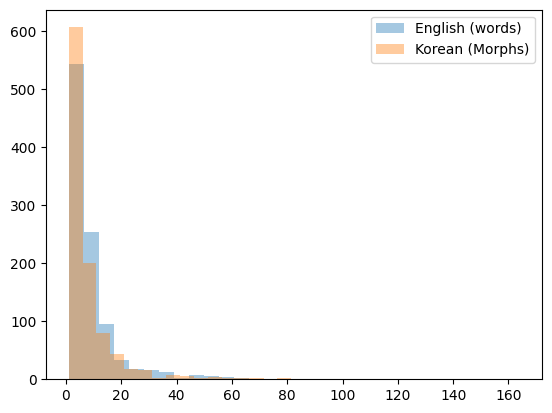

In [ ]:
# 문장길이 분석
from konlpy.tag import Okt
nltk.download('punkt_tab')
okt = Okt()
lengths_en = []
lengths_ko = []
for item in dataset:
  en_text = item['translation']['en']
  ko_text = item['translation']['ko']
  lengths_en.append(len(nltk.word_tokenize(en_text)))
  lengths_ko.append(len(okt.morphs(ko_text)))
# 히스토그램 시각화
plt.hist(lengths_en, bins=30, alpha=0.4, label = 'English (words)')
plt.hist(lengths_ko, bins=30, alpha=0.4, label = 'Korean (Morphs)')
plt.legend()
plt.show()

In [ ]:
from huggingface_hub import login
login('your_token')

In [ ]:
# 번역모델
import torch
import torch.nn as ann
device = 'cuda' if torch.cuda.is_available else 'cpu'

model_name = "Helsinki-NLP/opus-mt-tc-big-en-ko"
tokenizer =  MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)

In [ ]:
def translate(text):
  inputs = tokenizer(text, return_tensors="pt",padding=True, truncation=True).to(device)
  translated  = model.generate(**inputs)
  return tokenizer.decode(translated[0],skip_special_tokens = True )

from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
bleu_scores = []
sentence_lengths = []
from tqdm import tqdm
for item in tqdm(dataset):
  en_text = item['translation']['en'][:100]
  ko_text = item['translation']['ko'][:100]
  translated = translate(en_text)
  reference = [ko_text.split()]
  candidate = translated.split()
  bleu = sentence_bleu(reference, candidate,smoothing_function=smoothie)
  bleu_scores.append(bleu)
  sentence_lengths.append(len(candidate))

100%|██████████| 1000/1000 [04:13<00:00,  3.95it/s]


In [ ]:
print(dataset[100]['translation']['en'], dataset[100]['translation']['ko'])
candidate = translate(dataset[100]['translation']['en'])
print(type(candidate))
reference = [dataset[100]['translation']['ko'].split()]
print(translate(dataset[100]['translation']['en']))
sentence_bleu(reference, candidate,smoothing_function=smoothie)

But there's no trace of wreckage. 사고 잔해가 없는데요?
<class 'str'>
flip Instruments 호텔링 쿠킹은 청소를 수행합니다.


0

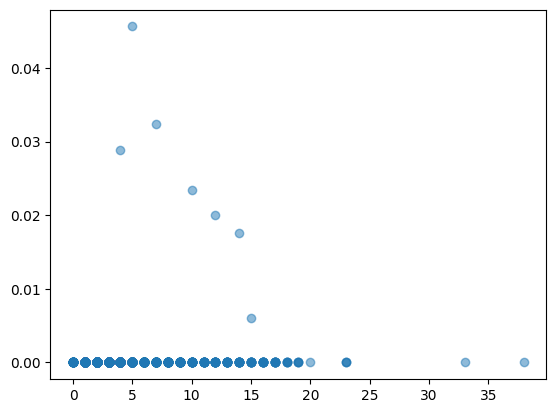

bleu 평균 : 0.0002


In [ ]:
# BLEU 스코어 시각화(문장길이에 따른 점수)
plt.scatter(sentence_lengths,bleu_scores,alpha=0.5)
plt.show()
print(f'bleu 평균 : {np.mean(bleu_scores):.4f}')

mBART(Cross-Ligual Pretrained)

In [ ]:
# Cross-Ligual Pretrained
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
from transformers import MT5Model, AutoTokenizer, MT5ForConditionalGeneration

mbart50_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt").to(device)
mbart50_tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
# mT5 Deep Encoder

mt5_model = MT5ForConditionalGeneration.from_pretrained("csebuetnlp/mT5_multilingual_XLSum").to(device)
mt5_tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/mT5_multilingual_XLSum")

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
def translate_mbart(text):
  # translate English to korean
  mbart50_tokenizer.src_lang = "en_XX"
  encoded_ar = mbart50_tokenizer(text, return_tensors="pt").to(device)
  generated_tokens = mbart50_model.generate(
    **encoded_ar,
    forced_bos_token_id=mbart50_tokenizer.lang_code_to_id["ko_KR"]
  )
  return mbart50_tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

def translate_mt5(text):
  # text = f"translate English to Korean: {text} "
  inputs = mt5_tokenizer(text, return_tensors="pt",padding=True, truncation=True).to(device)
  translated  = mt5_model.generate(**inputs,max_length=128,num_beams=4)
  return mt5_tokenizer.decode(translated[0],skip_special_tokens = True )

In [ ]:
dataset[150]['translation']['en'], dataset[150]['translation']['ko']

('Your sisters thought I should send it along, but I wanted to be here to see your face when it arrived, so last week, I called Jackson.',
 '네 동생이 나중에 보내라고 했는데 이게 도착했을 때, 네 얼굴을 보고 싶어서 그래서 지난주에, 잭슨한테 전화했지')

In [ ]:
translate(dataset[150]['translation']['en'])

'할머니 Usyle CD 표현, 수용 US 심장 대학 킨 방콕 쌍 CD, 쐐기의 원인, US 해명.'

In [ ]:
translate(dataset[150]['translation']['en'])

'할머니 Usyle CD 표현, 수용 US 심장 대학 킨 방콕 쌍 CD, 쐐기의 원인, US 해명.'

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
bleu_scores = []
sentence_lengths = []
from tqdm import tqdm
for item in tqdm(dataset):
  en_text = item['translation']['en']
  ko_text = item['translation']['ko']
  translated = translate_mbart(en_text)[0]
  reference = [ko_text.split()]
  candidate = translated.split()
  bleu = sentence_bleu(reference, candidate,smoothing_function=smoothie)
  bleu_scores.append(bleu)
  sentence_lengths.append(len(candidate))


100%|██████████| 1000/1000 [05:08<00:00,  3.24it/s]


In [ ]:
bleu_scores

[0,
 0,
 0.04566525607137944,
 0,
 0.03701851938020757,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08125011970110721,
 0,
 0,
 0,
 0,
 0,
 0,
 0.03182213000550693,
 0.0250530827696685,
 0.08125011970110721,
 0.16821895003341453,
 0.07249749990681824,
 0,
 0.13100905001347277,
 0,
 0,
 0,
 0.03759340464156993,
 0.09717716588732002,
 0,
 0.06754436142034707,
 0.03759340464156993,
 0,
 0,
 0.07249749990681824,
 0,
 0,
 0,
 0.05159912585823018,
 0.014936192853457254,
 0.06754436142034707,
 0,
 0.05194672862155564,
 0,
 0.07249749990681824,
 0,
 0.081939171811711,
 0.0456496931223525,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.028599617161713803,
 0,
 0.017762226812384152,
 0,
 0,
 0,
 0,
 0,
 0.033866335496821456,
 0,
 0,
 0,
 0,
 0.012368469101174938,
 0.07790941292260128,
 0,
 0,
 0.01214595417412267,
 0.43146827293898643,
 0,
 0.01758542189440898,
 1.0,
 0,
 0,
 0.06321087140417253,
 0,
 0,
 0,
 0,
 0.02266357778217241,
 0,
 0,
 1.0,
 0.07249749990681824,
 0,
 0,
 0,
 0,
 0.2213885886251307,
 0.0675443

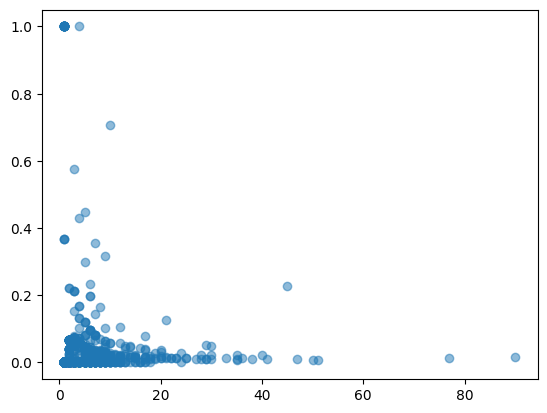

bleu 평균 : 0.0400


In [ ]:
# BLEU 스코어 시각화(문장길이에 따른 점수)
plt.scatter(sentence_lengths,bleu_scores,alpha=0.5)
plt.show()
print(f'bleu 평균 : {np.mean(bleu_scores):.4f}')

사전학습 모델 구조 비교 / 전략
```
  MarianMT:
    구조 : 경량화된 트랜스포머, 레이어를공유, 최적화
    특징 : 특징언어쌍(영어->한국어)에 특화된 소규모 모델
    장점 :
    단점 : 다국어 일반화능력이 제한, 긴문장 처리 약함
  mBART:
    구조 : 다국어사전학습 트랜스포머, 노이즈제거 오토인코딩  학습
    특징 : 50개이상 언어지원, 문맥이해 강함
  mT5:
    구조 : seq2seq구조에서 깊은 인코더-디코더
    특징 : 입력테스크를 모두 입/출력으로 처리 다국어지원
  NLLB:
    구조 : Meta AI의 대규모 자연어 모델 200개이상의 언어
    특징 : 저차원 언어에 특화
    단점 : 코렙에 X  리소스가 너무큼
```

모델선택 : 상황에 맞는 모델 및 전략
```
  Fine-tunning
    특정언어쌍이나 도메인 데이터로 모델 미세 조정
  Zero-shot
    사전학습된 모델로 추가 학습없이 바로 사용
  Few-shot
    소량데이터(10~100)로 빠르게 학습 및 모델데이터의 도메인변경
```

mT5 모델 Few-shot

In [ ]:
dataset = load_dataset("opus100", "en-ko", split="train[:1000]")
from transformers import T5Tokenizer, T5ForConditionalGeneration,Trainer, TrainingArguments
import  torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 테스트문장10 ,few-shot 100개
test_data = dataset.select(range(2,12))
train_data = dataset.select(range(12,112)) # 소량데이터
mt5_model_name = 'google/mt5-small'
mt5_tokenizer = T5Tokenizer.from_pretrained(mt5_model_name)
mt5_model = T5ForConditionalGeneration.from_pretrained(mt5_model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# 번역함수
def translate_mt5(text):
  prompt = f"translate English to Korean: {text} "
  inputs = mt5_tokenizer(prompt, return_tensors="pt",padding=True).to(device)
  translated  = mt5_model.generate(**inputs)
  return mt5_tokenizer.decode(translated[0],skip_special_tokens = True )
#few shot 튜닝
# 데이터를 전치리
def preprocess_mt5(examples):
    inputs = [f"translate English to Korean: {ex['en']}" for ex in examples['translation']]
    targets = [ex['ko'] for ex in examples['translation']]

    model_inputs = mt5_tokenizer(inputs, max_length=128, truncation=True, padding='max_length')
    labels = mt5_tokenizer(targets, max_length=128, truncation=True, padding='max_length')

    model_inputs['labels'] = labels['input_ids']
    return model_inputs
# 학습용데이터 에 전처리 함수 적용
train_dataset = train_data.map(preprocess_mt5,batched=True)
# Trainer 설정
train_args = TrainingArguments(
    output_dir='./results',
    # evaluation_strategy='no',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs = 3,
    weight_decay = 0.01,
    save_strategy='epoch',
    logging_steps = 10,
    report_to = 'none'  # 별도의 출력 프레임웍 사용 안함 wedb
)
trainer = Trainer(
    model=mt5_model,
    args=train_args,
    train_dataset=train_dataset
)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# 파인튜닝(few-shot)
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,61.652300
20,60.205100
30,57.621400
40,58.076900
50,54.899100
60,55.795500
70,57.584700


TrainOutput(global_step=75, training_loss=57.83698038736979, metrics={'train_runtime': 136.741, 'train_samples_per_second': 2.194, 'train_steps_per_second': 0.548, 'total_flos': 39656226816000.0, 'train_loss': 57.83698038736979, 'epoch': 3.0})

In [ ]:
# few-shot 데이터셋
data = [
    ("Hello, how are you?", "안녕하세요, 어떻게 지내세요?"),
    ("I am going to the market.", "저는 시장에 가고 있습니다."),
    ("What time is the meeting?", "회의는 몇 시에 시작하나요?"),
    ("She loves to read books.", "그녀는 책 읽는 것을 좋아합니다."),
    ("We need to finish the project by tomorrow.", "우리는 내일까지 프로젝트를 끝내야 합니다."),
    ("Can you help me with this task?", "이 작업을 도와줄 수 있나요?"),
    ("It's raining heavily today.", "오늘 비가 많이 내리고 있습니다."),
    ("The movie was very interesting.", "그 영화는 매우 흥미로웠습니다."),
    ("I will call you later.", "나중에 전화할게요."),
    ("They are planning a trip to Korea.", "그들은 한국 여행을 계획하고 있습니다."),
    ("Where is the nearest bus stop?", "가장 가까운 버스 정류장은 어디인가요?"),
    ("Please send me the report by email.", "이메일로 보고서를 보내주세요."),
    ("I forgot my password.", "비밀번호를 잊어버렸어요."),
    ("We will meet at the coffee shop.", "우리는 커피숍에서 만날 거예요."),
    ("This cake tastes delicious.", "이 케이크 정말 맛있어요."),
    ("Could you open the window?", "창문을 열어줄 수 있나요?"),
    ("My phone battery is dead.", "제 휴대폰 배터리가 다 닳았어요."),
    ("I like to listen to music.", "저는 음악 듣는 것을 좋아해요."),
    ("Let's have dinner together.", "같이 저녁 먹어요."),
    ("I'm looking for a new job.", "새 직장을 찾고 있어요."),
    ("He is a very talented musician.", "그는 매우 재능 있는 음악가입니다."),
    ("Please wait a moment.", "잠시만 기다려 주세요."),
    ("Can I try this on?", "이거 입어봐도 될까요?"),
    ("The weather is getting colder.", "날씨가 점점 추워지고 있어요."),
    ("I will be there in five minutes.", "5분 안에 도착할게요."),
    ("Turn left at the next corner.", "다음 모퉁이에서 좌회전하세요."),
    ("She speaks three languages fluently.", "그녀는 세 가지 언어를 유창하게 말합니다."),
    ("We had a great time yesterday.", "우리는 어제 정말 즐거운 시간을 보냈어요."),
    ("I need some rest.", "저는 좀 쉬어야 해요."),
    ("The store closes at 9 p.m.", "그 가게는 오후 9시에 문을 닫아요."),
    ("Could you recommend a good restaurant?", "좋은 식당 추천해줄 수 있나요?"),
    ("I lost my wallet.", "지갑을 잃어버렸어요."),
    ("Let's watch a movie tonight.", "오늘 밤 영화 보자."),
    ("I have a lot of homework to do.", "해야 할 숙제가 많아요."),
    ("This room needs cleaning.", "이 방은 청소가 필요해요."),
    ("I like your new haircut.", "새로운 헤어스타일이 마음에 들어요."),
    ("Please turn off the lights.", "불을 꺼주세요."),
    ("The book is on the table.", "책은 테이블 위에 있어요."),
    ("We traveled to Paris last summer.", "우리는 지난 여름에 파리를 여행했어요."),
    ("There is a problem with the computer.", "컴퓨터에 문제가 있어요."),
    ("I'm afraid I can't come today.", "죄송하지만 오늘은 갈 수 없어요."),
    ("How much is this jacket?", "이 재킷은 얼마인가요?"),
    ("I need to buy some groceries.", "장 봐야 해요."),
    ("We should leave early.", "우리는 일찍 출발해야 해요."),
    ("Could you speak more slowly?", "조금 천천히 말씀해주실 수 있나요?"),
    ("The meeting was very productive.", "회의가 매우 생산적이었어요."),
    ("I usually wake up at 7 a.m.", "저는 보통 오전 7시에 일어나요."),
    ("I'm not feeling well today.", "오늘 몸이 좀 안 좋아요."),
    ("I enjoy hiking in the mountains.", "산에서 하이킹하는 것을 즐깁니다."),
    ("What did you do over the weekend?", "주말에 뭐 했어요?"),
    ("Please write it down.", "그걸 적어주세요."),
    ("He forgot to bring his passport.", "그는 여권을 가져오는 것을 잊었어요."),
    ("We are moving to a new house.", "우리는 새 집으로 이사할 거예요."),
    ("This coffee is too hot.", "이 커피는 너무 뜨거워요."),
    ("She has a beautiful voice.", "그녀는 아름다운 목소리를 가지고 있어요."),
    ("I’m interested in learning Korean.", "저는 한국어 배우는 것에 관심이 있어요."),
    ("Do you have any plans for the holiday?", "연휴에 계획 있어요?"),
    ("The park is very crowded today.", "오늘 공원이 매우 붐벼요."),
    ("Please close the door quietly.", "조용히 문을 닫아주세요."),
    ("I will send you the details later.", "자세한 내용을 나중에 보내드릴게요."),
    ("It's important to stay healthy.", "건강을 유지하는 것이 중요해요."),
    ("They arrived at the airport on time.", "그들은 제시간에 공항에 도착했어요."),
    ("The food smells amazing.", "음식 냄새가 정말 좋아요."),
    ("I'm sorry for the inconvenience.", "불편을 드려 죄송합니다."),
    ("He runs faster than me.", "그는 나보다 빨리 달립니다."),
    ("Let’s start the meeting.", "회의를 시작합시다."),
    ("Can I pay by credit card?", "신용카드로 결제할 수 있나요?"),
    ("She wants to become a doctor.", "그녀는 의사가 되고 싶어해요."),
    ("We will have lunch together.", "우리는 함께 점심을 먹을 거예요."),
    ("Turn the volume down, please.", "볼륨을 낮춰주세요."),
    ("I have been waiting for an hour.", "저는 한 시간 동안 기다렸어요."),
    ("The train was delayed.", "기차가 지연됐어요."),
    ("He didn't understand the question.", "그는 질문을 이해하지 못했어요."),
    ("Thank you for your help.", "도와주셔서 감사합니다."),
    ("Please come in.", "들어오세요."),
    ("The museum is closed on Mondays.", "박물관은 월요일에 문을 닫습니다."),
    ("We met at a conference last year.", "우리는 작년에 한 컨퍼런스에서 만났어요."),
    ("I need to charge my laptop.", "노트북을 충전해야 해요."),
    ("This song is very popular.", "이 노래는 매우 인기가 있어요."),
    ("I will check the schedule.", "일정을 확인할게요."),
    ("He has a meeting this afternoon.", "그는 오늘 오후에 회의가 있어요."),
    ("It's my first time visiting Korea.", "한국을 방문하는 것은 처음입니다."),
    ("Can you recommend a good hotel?", "좋은 호텔을 추천해주실 수 있나요?"),
    ("I heard it’s going to snow tomorrow.", "내일 눈이 온다고 들었어요."),
    ("Let's go for a walk.", "산책하러 가자."),
    ("She bought a new laptop yesterday.", "그녀는 어제 새 노트북을 샀어요."),
    ("This room has a nice view.", "이 방은 전망이 좋아요."),
    ("I'm learning how to cook Korean food.", "저는 한국 음식을 요리하는 법을 배우고 있어요."),
    ("He works at a bank.", "그는 은행에서 일합니다."),
    ("Please be careful.", "조심하세요."),
    ("The bus was very crowded.", "버스가 매우 붐볐어요."),
    ("Can you recommend a good book?", "좋은 책 추천해줄 수 있나요?"),
    ("I'm traveling to Japan next month.", "다음 달에 일본으로 여행을 갑니다."),
    ("She is preparing for the exam.", "그녀는 시험 준비를 하고 있어요."),
    ("The weather will be sunny tomorrow.", "내일은 맑을 거예요."),
    ("I'm so happy to see you.", "당신을 만나서 정말 기뻐요."),
    ("The food was delicious.", "음식이 정말 맛있었어요."),
    ("I’ll be back soon.", "곧 돌아올게요."),
]

In [ ]:
!pip install konlpy

In [ ]:
from konlpy.tag import Okt
okt = Okt()
text = '영어-한국어 번역 성능을 향상시킵니다.'
okt.morphs(text)

['영어', '-', '한국어', '번역', '성능', '을', '향상', '시킵니다', '.']

In [ ]:
okt.pos(text)

[('영어', 'Noun'),
 ('-', 'Punctuation'),
 ('한국어', 'Noun'),
 ('번역', 'Noun'),
 ('성능', 'Noun'),
 ('을', 'Josa'),
 ('향상', 'Noun'),
 ('시킵니다', 'Verb'),
 ('.', 'Punctuation')]

In [ ]:
!pip install kss

In [ ]:
# 한국어 문장 분리 : kss.split_sentences() + okt 결합
from kss import split_sentences
sentences = split_sentences("복잡한 문장입니다. 형태소 분석이 필요합니다.")
tokens = [okt.morphs(sent) for sent in sentences]
tokens

[['복잡한', '문장', '입니다', '.'], ['형태소', '분석', '이', '필요합니다', '.']]

In [ ]:
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
from transformers import MT5ForConditionalGeneration,AutoTokenizer
model = MT5ForConditionalGeneration.from_pretrained('google/mt5-base').to(device)
tokenizer = AutoTokenizer.from_pretrained('google/mt5-base')

# from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
# model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
# tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")

In [ ]:
# 데이터 전처리 함수
def preprocess_korean(text):
  tokens = okt.morphs(text, stem=True)
  return ' '.join(tokens)

def create_prompt(src_text, examples):
  prompt = '번역 예시:\n'
  for src, tgt in zip(examples['src'].to_list(), examples['tgt'].to_list()):
    prompt += f"{src} -> {preprocess_korean(tgt)}\n"
  prompt += f"입력: {src_text}\n출력:"
  return prompt
# 추론 함수
def translate(text, examples, max_length=128)  :
  prompt = create_prompt(text, examples)
  # 토크나이징
  inputs = tokenizer(prompt, return_tensors="pt",padding=True, truncation=True, max_length=512).to(device)
  # 생성
  outputs = model.generate(**inputs,max_length=max_length, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
  # 디코딩
  translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
  return translated_text.replace(' ', '').replace('_', ' ')

In [ ]:
import pandas as pd
df = pd.DataFrame(data, columns=['src','tgt'])
test_text = "He is reading a newspaper."
result = translate(test_text, df[:2])
result

'<extra id 0>에의해번역'

In [ ]:
create_prompt("thank you very much", df.iloc[:1])

'번역 예시:\nHello, how are you? -> 안녕하다 , 어떻다 지내다 ?\n입력: thank you very much\n출력:'

In [ ]:
df[:2]

,src,tgt
0,"Hello, how are you?","안녕하세요, 어떻게 지내세요?"
1,I am going to the market.,저는 시장에 가고 있습니다.


병렬 말뭉치 전처리 및 데이터 품질 평가
```
  병렬 말뭉치( 영어-한국어) 쌍의 데이터 셋
  문제:
    노이즈 : 오타,잘못된 번역
    길이 불일치 : 영어문장 5단어, 한국어문장 20형태소
    희소 단어 : 고유명사(엔코어), 전문용어
    정렬 오류: 쌍이 잘못되었을때
  전처리목표
    노이즈제거, 문장길이 균형 맞추기, 데이터 정규화
    품질높은 데이터로 모델성능 향상(fine tunning이 가능한)
  데이터품질 평가방법
    길이비율 분석:
      영어단어수와 한국어 형태소 수 의 비율계산(ex 1 : 1.5면 이상치)
      이상치제거로 학습데이터 균형 유지
    BLUE 스코어:
      참조번역(원본한국어)와 모델번역간의 BLUE 품질비교
      데이터 자체의 번역 정합성 점검
    희소단어 빈도:
      고유명사나 드문 단어 빈도 분석
      희소단어 다수포함-> 파인튜닝 데이터 보강 필요
    정렬점검
      문장쌍의 의미적 유사성 확인(ex SBERT로 코사인 유사도)
```

In [ ]:
!pip install konlpy
!pip install transformers datasets

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from datasets import load_dataset
dataset = load_dataset("opus100", "en-ko", split="train[:1000]")
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

original data size : 1000
cleaned data size : 648


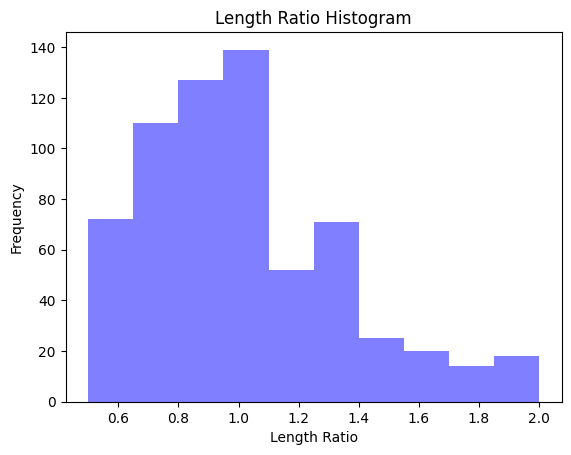

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import re
# 데이터 전처리 - 특수문자 제거, 한글(okt정규화), 영어(소문자)
def preprocess_text(text, lang='en'):
  text = text.lower()  # 영어 소문자로 변환
  text = re.sub(r'[^\w\s.,!?]', '',text)  # 알파벳/숫자/공백/마침표/쉼표/느낌표/물음표를 제외한 문자는 제거
  text = re.sub(r'\s+', ' ',text).strip()  #연속된 공백은 하나의 공백
  if lang == 'ko':
    tokens = okt.morphs(text,norm=True)
    text = ' '.join(tokens)
  return text

# 길이비율
def length_ratio(en_text, ko_text):
  en_word = len(nltk.word_tokenize(en_text))
  ko_word = len(okt.morphs(ko_text))
  assert en_word !=0 ,"영어 텍스트가 비어있습니다.(길이가 0임)"
  return ko_word / en_word

# 전처리 및 필터링
cleaned_data = []
length_ratios = []
for item in dataset['translation']:
  en_text = preprocess_text(item['en'])
  ko_text = preprocess_text(item['ko'], lang='ko')
  # 길이 계산
  en_len = len(nltk.word_tokenize(en_text))
  ko_len = len(okt.morphs(ko_text))
  ratio = length_ratio(en_text, ko_text)
  # 필터링 조건 : 각 문장의길이가 3이상이고 raio는 1:0.5 ~ 1:2
  if en_len >= 3 and ko_len >= 3 and 0.5 <= ratio <= 2:
    cleaned_data.append({'en': en_text, 'ko': ko_text})
    length_ratios.append(ratio)

print(f"original data size : {len(dataset)}")
print(f"cleaned data size : {len(cleaned_data)}")

# 길이비율 히스토그램
import matplotlib.pyplot as plt
plt.hist(length_ratios, bins=10, alpha=0.5, color='blue')
plt.xlabel('Length Ratio')
plt.ylabel('Frequency')
plt.title('Length Ratio Histogram')
plt.show()

In [ ]:
from collections import Counter
from transformers import MT5ForConditionalGeneration, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset
import pandas as pd
import torch

# 희소단어 빈도 분석
ko_tokens = []
for item in cleaned_data:
    tokens = okt.morphs(item['ko'], norm=True)
    ko_tokens.extend(tokens)

ko_counter = Counter(ko_tokens)
rare_tokens = {token: count for token, count in ko_counter.items() if count <= 2}

print(f'total token : {len(ko_tokens)}')
print(f'rare token : {len(rare_tokens)}')
print(f'top5 frequency : {ko_counter.most_common(5)}')

# 모델 및 토크나이저 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MT5ForConditionalGeneration.from_pretrained('google/mt5-base').to(device)
tokenizer = AutoTokenizer.from_pretrained('google/mt5-base')

# 번역 함수
def translate(text, model):
    model.eval()
    input_text = f"translate English to Korean: {text}"
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        translated = model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# 데이터셋 생성
cleaned_dataset = Dataset.from_pandas(pd.DataFrame(cleaned_data, columns=['en', 'ko']))

# 전처리 함수
def preprocess_mt5(batch):
    inputs = [f"translate English to Korean: {text}" for text in batch["en"]]
    targets = batch["ko"]

    model_inputs = tokenizer(
        inputs, max_length=128, truncation=True, padding="max_length"
    )
    labels = tokenizer(
        targets, max_length=128, truncation=True, padding="max_length"
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# ✅ 전처리 적용 (정상 batched=True)
train_dataset = cleaned_dataset.map(preprocess_mt5, batched=True)

# 학습 설정
train_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy='epoch',
    logging_steps=10,
    report_to='none',
    remove_unused_columns=False
)

# 트레이너 정의
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)

# 모델 학습
trainer.train()

# 평가 예시
print("Sample translation:")
print("EN:", cleaned_data[1]['en'])
print("KO (Generated):", translate(cleaned_data[1]['en'], model))

total token : 7197
rare token : 1997
top5 frequency : [('을', 225), ('이', 199), ('들', 174), ('그', 164), ('은', 136)]


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/648 [00:00<?, ? examples/s]

<ipython-input-123-10e9756c1784>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


ValueError: Unable to create tensor, you should probably activate truncation and/or padding with 'padding=True' 'truncation=True' to have batched tensors with the same length. Perhaps your features (`en` in this case) have excessive nesting (inputs type `list` where type `int` is expected).